In [1]:
import pandas as pd
import numpy as np
from numpy import arange
import itertools
import time

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import autocorrelation_plot
from kneed import KneeLocator

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tools.eval_measures import rmse

from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold, GridSearchCV, RepeatedKFold

# **1 Data Setup**

### Data Pre-Processing 

In [2]:
data_path = '/Users/maggie/Documents/Github/LogisticRegression_HPDmobile/H1_RS4_prob.csv'

start_date = '2019-11-26 00:00:00'
end_date = '2019-12-26 00:00:00'

In [5]:
#Import data
df = pd.read_csv(data_path, parse_dates = ["timestamp"])

#df1 is created seperately for the lag values, used in later sections. 
df1 = df.copy()
df1 = df1.fillna(0)

# Create 5 min averages.
df1.set_index("timestamp", inplace=True)
df1.index = pd.to_datetime(df1.index)
df1 = df1.resample(rule = '5min').mean()

#Occupied round 1 or 0. 
df1["occupied"] = df1["occupied"].apply(lambda x: 1 if (x >= 0.5) else 0)

#30 day interval: 2019-11-26 through 2019-12-25
df = (df[(df['timestamp'] >= start_date) & (df['timestamp'] < end_date)])

#Determine the distribution of NaN values. 
count_nan_df = len(df) - df.count()
print('df', count_nan_df)

#forward fill NaN values - when investigating data. 
#df = df.fillna(method = "ffill")
#fill NaN with 0
df = df.fillna(0)

# Create 5 min averages.
df.set_index("timestamp", inplace=True)
df.index = pd.to_datetime(df.index)
df_avg = df.resample(rule = '5min').mean()

#round occupied/unoccupied
df_avg["occupied"] = df_avg["occupied"].apply(lambda x: 1 if (x >= 0.5) else 0)

#view first 5 rows of data. 
df_avg.tail()

df timestamp         0
hub               0
audio         11002
co2eq             0
light             0
rh                0
temp              0
img          126369
occupied       1355
dtype: int64


,audio,co2eq,light,rh,temp,img,occupied
timestamp,,,,,,,
2019-12-25 23:35:00,0.017800,0.806206,0.883883,1.000000,0.810217,0.0,0
2019-12-25 23:40:00,0.018271,0.806206,0.883883,0.987051,0.810217,0.0,0
2019-12-25 23:45:00,0.009635,0.806206,0.883883,0.971828,0.810217,0.0,0
2019-12-25 23:50:00,0.034479,0.806206,0.883883,0.974527,0.810217,0.0,0
2019-12-25 23:55:00,0.028034,0.806206,0.883883,0.987476,0.810217,0.0,0


### Offsetting Data

In [6]:
#keep last 8 hours from 11-25
df_1 = (df1.occupied[(df1.index >= '2019-11-25 16:00:00') & (df1.index < '2019-12-26 00:00:00')])

#convert to series
OA = pd.Series(df_1)

# 96 equal 8 hours for lag // add to dataframe
df_avg["lag8_occupied"] = OA.shift(periods=96)
df_avg["lag7_occupied"] = OA.shift(periods=84)
df_avg["lag6_occupied"] = OA.shift(periods=72)
df_avg["lag5_occupied"] = OA.shift(periods=60)
df_avg["lag4_occupied"] = OA.shift(periods=48)
df_avg["lag3_occupied"] = OA.shift(periods=36)
df_avg["lag2_occupied"] = OA.shift(periods=24)
df_avg["lag1_occupied"] = OA.shift(periods=12)

# **3 Model Construction**

#### Define Functions

In [19]:
def plot_alphas(alpha_list, model_fcn, X_train, y_train):
    
    model = model_fcn()
    coefs = []
    
    for a in alpha_list:
        model.set_params(alpha=a)
        model.fit(X_train, y_train)
        coefs.append(model.coef_)
        
    ax = plt.gca()
    ax.plot(alpha_list, coefs)
    ax.set_xscale('log')
    plt.axis('tight')
    plt.xlabel('alpha')
    plt.ylabel('Coefs')
    ax.legend(X_train, prop={'size': 10})
    plt.show()

In [17]:
def compute_alphas(alpha_list, model_fcn, X_train, y_train, X_test, y_test):
    for a in alpha_list:
        print(f'\nalpha: {a}')
        model = model_fcn(alpha=a)
        model.fit(X_train, y_train)
        pred_train = model.predict(X_train)
        
        print("RMSE Data:", np.sqrt(mean_squared_error(y_train, pred_train)))
        print("R-Squared Data:", r2_score(y_train, pred_train))
        
        pred_test = model.predict(X_test)
        print("RMSE Predict:", np.sqrt(mean_squared_error(y_test, pred_test)))
        print("R-Squared Predict:", r2_score(y_test, pred_test))
        
        print("Model Intercept:", (model.intercept_))
        print("Model Coefficents:")
        print(pd.Series(model.coef_, index = X_train.columns))  

In [23]:
def CV_calculate(cv, model_cv_fcn, model_fcn, X_train, y_train, X_test, y_test, alpha_list=None):

    cv_model = model_cv_fcn(alphas=alpha_list, cv=cv)
    cv_model.fit(X_train, y_train)

    model = model_fcn(alpha=cv_model.alpha_)
    model.fit(X_train, y_train)
    
    print("RMSE: ", rmse(y_test, model.predict(X_test)))
    print(pd.Series(model.coef_, index=X_test.columns))
    
    print("Alpha: ", cv_model.alpha_)
    print("Intercept: ", (cv_model.intercept_))
    print("R-Squared: ", r2_score(y_test, model.predict(X_test)))
    
    
# This yields slightly different values than Jasmine's original

In [12]:
#Create LR function 
def LR(X_train):
    logit_mod = sm.Logit(y_train, X_train)
    logit_res = logit_mod.fit()
    print(logit_res.summary())

    logit_test_probs = logit_res.predict(X_test)
    logit_test_preds = pd.Series(logit_test_probs).apply(lambda x: 1 if (x > 0.5) else 0)

    mat = pd.DataFrame(confusion_matrix(logit_test_preds, y_test), columns = ["Unoccupied", "Occupied"], index = ["Unoccupied", "Occupied"])
    fig, ax = plt.subplots()
    sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"})
    ax.set(xlabel = "predicted label", ylabel = "true label")

    r_squared = r2_score(y_test, logit_test_preds)

    print("AIC:", logit_res.aic)
    print("RMSE:", rmse(y_test, logit_test_preds))
    print("R-Squared:", r2_score(y_test, logit_test_preds))
    adjusted_r_squared = 1 - (1-r_squared)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
    print("Adj. R-Squared:", adjusted_r_squared)

#### Create test/train split

In [11]:
# split the data into test/train
y_train = (df_avg.occupied[(df_avg.index >= '2019-11-26 00:00:00') & (df_avg.index < '2019-12-15 00:00:00')])

X_train = sm.add_constant(df_avg[(df_avg.index >= '2019-11-26 00:00:00') & (df_avg.index < '2019-12-15 00:00:00')])
X_train = X_train.drop(columns=["occupied","img", "audio","co2eq", "light", "rh", "temp"])

y_test = (df_avg.occupied[(df_avg.index >= '2019-12-15 00:00:00')])

X_test = sm.add_constant(df_avg[(df_avg.index >= '2019-12-15 00:00:00')])
X_test = X_test.drop(columns=["occupied","img", "audio","co2eq", "light", "rh", "temp"])

### 3.1 AR Models

#### 3.1.0 Baseline model

Optimization terminated successfully.
         Current function value: 0.233208
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               occupied   No. Observations:                 5472
Model:                          Logit   Df Residuals:                     5463
Method:                           MLE   Df Model:                            8
Date:                Tue, 19 Jan 2021   Pseudo R-squ.:                  0.5419
Time:                        19:01:04   Log-Likelihood:                -1276.1
converged:                       True   LL-Null:                       -2785.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.6050      0.134     -4.528      0.000      -0.867      -0.343
lag8_occupied    -1.

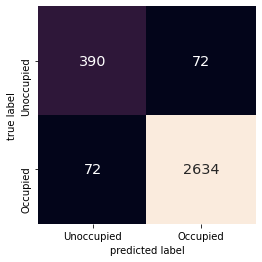

In [21]:
LR(X_train)

#### 3.1.1 AR Lasso

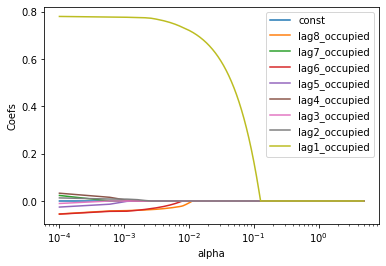


alpha: 1
RMSE Data: 0.40466514312812796
R-Squared Data: 0.0
RMSE Predict: 0.3580851630867463
R-Squared Predict: -0.029374087765412504
Model Intercept: 0.7936769005847953
Model Coefficents:
const            0.0
lag8_occupied   -0.0
lag7_occupied   -0.0
lag6_occupied    0.0
lag5_occupied    0.0
lag4_occupied    0.0
lag3_occupied    0.0
lag2_occupied    0.0
lag1_occupied    0.0
dtype: float64

alpha: 0.001
RMSE Data: 0.2509441753543697
R-Squared Data: 0.6154412958690803
RMSE Predict: 0.20514957912617562
R-Squared Predict: 0.6621360628040047
Model Intercept: 0.23501536342273055
Model Coefficents:
const            0.000000
lag8_occupied   -0.040914
lag7_occupied    0.000000
lag6_occupied   -0.043354
lag5_occupied   -0.003880
lag4_occupied    0.005754
lag3_occupied    0.000000
lag2_occupied    0.007951
lag1_occupied    0.777288
dtype: float64

alpha: 0.005
RMSE Data: 0.25177464066014515
R-Squared Data: 0.6128917957277755
RMSE Predict: 0.20548136335694667
R-Squared Predict: 0.661042338177992

In [62]:
# Graph alphas for lasso
alphas_lassoPlot = np.linspace(0.0001, 5, num=10000)
plot_alphas(alpha_list=alphas_lassoPlot, model_fcn=Lasso,
            X_train=X_train, y_train=y_train)

# Lasso regresson loop
alpha_lasso = [1, 0.001, 0.005, 0.01, 0.02,0.09, 0.13, 10]
compute_alphas(alpha_list=alpha_lasso, model_fcn=Lasso, 
               X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

# Lasso CV
cv = KFold(n_splits=5)
CV_calculate(cv=cv, model_fcn=Lasso, model_cv_fcn=LassoCV, 
             X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

#### 3.1.2 AR Ridge

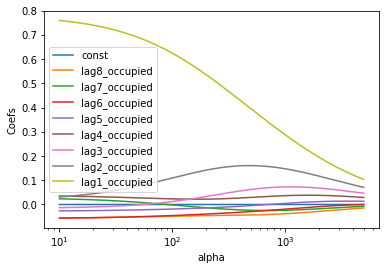


alpha: 1
RMSE Data: 0.2507500001654555
R-Squared Data: 0.6160361920783248
RMSE Predict: 0.20570990123273608
R-Squared Predict: 0.6602879365025108
Model Intercept: 0.23508471566977995
Model Coefficents:
const            0.000000
lag8_occupied   -0.057416
lag7_occupied    0.027937
lag6_occupied   -0.057881
lag5_occupied   -0.027854
lag4_occupied    0.037482
lag3_occupied   -0.015335
lag2_occupied    0.017099
lag1_occupied    0.778795
dtype: float64

alpha: 10
RMSE Data: 0.25080852494173084
R-Squared Data: 0.6158569376947456
RMSE Predict: 0.2056502560056983
R-Squared Predict: 0.6604849057834074
Model Intercept: 0.23919074246616767
Model Coefficents:
const            0.000000
lag8_occupied   -0.055799
lag7_occupied    0.023596
lag6_occupied   -0.056232
lag5_occupied   -0.026525
lag4_occupied    0.034956
lag3_occupied   -0.013008
lag2_occupied    0.030995
lag1_occupied    0.759656
dtype: float64

alpha: 100
RMSE Data: 0.2539519872087221
R-Squared Data: 0.6061674229022924
RMSE Predict: 0.20

In [61]:
# Graph alphas for ridge
alphas_ridgePlot = np.linspace(10, 5000, num=10000)
plot_alphas(alpha_list=alphas_ridgePlot, model_fcn=Ridge,
            X_train=X_train, y_train=y_train)

# Ridge Regression Loop
alpha_ridge = [1,10, 100, 500, 1000, 2500, 5000]
compute_alphas(alpha_list=alpha_ridge, model_fcn=Ridge,
               X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

# Ridge CV
alphas_ridgeCV = np.arange(0.0001,1000,1)
cv = RepeatedKFold(n_splits=5, n_repeats=2)
CV_calculate(cv=cv, model_fcn=Ridge, model_cv_fcn=RidgeCV, alpha_list=alphas_ridgeCV,
             X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

#### 3.1.3 AR Best Subset Selection